# Regressão Linear Múltipla

---  

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import normaltest
from scipy.stats import pearsonr

In [68]:
# color pallete
colors ={
    'cyan': '#1696d2',
    'gray': '#5c5859',
    'black': '#000000',
    'yellow': '#fdbf11',
    'orange': '#ca5800',
    'magenta': '#af1f6b',
    'green': '#408941',
    'red': '#a4201d'
}

In [2]:
print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Seaborn: {sns.__version__}')
print(f'Statsmodels.api: {sm.__version__}')

Numpy: 1.20.3
Pandas: 1.3.4
Seaborn: 0.11.2
Statsmodels.api: 0.12.2


## 1. Previsão do Saldo Médio do Cartão de Crédito

Neste case, você deverá aplicar a regressão linear múltipla para **estimar o saldo médido** do cartão de crédito de clientes de um banco, a partir das demais informações contidas no conjunto de dados (credit_regression.csv), os quais são descritos abaixo. Aplique a regressão linear, utilizando o LinearRegression do sklearn e, também, o OLS do statsmodels.  

- ID - Identificação  
- Income - Renda  
- Limit - Limite de crédito  
- Rating - Score do Serasa  
- Age - Idade  
- Education - Anos de educação  
- Gender - Gênero  
- Student - É estudante? (Sim ou Não)  
- Married - É casado(a)? (Sim ou Não)  
- Ethnicity - Afro-americano, asiático ou branco  
- Balance - Saldo médio do cartão de crédito em dólares  


Dados adicionais  

- Credit card Balance refers to the average monthly balance across all of the cards owned by a cardholder. 
This assumption was made as a result of the Cards variable which refers to the number of credit cards owned by a person and has only one associated Balance figure.  
- The Balance is calculated as the highest amount incurred on a credit card in a given month. 
For example if a cardholder spends $400, $500, and $600 over the course of three months, and each month pays the balance in full, the average balance will be recorded as $500 (i.e. any preliminary balances before the maximum are not taken into account, neither is the final balance of zero).  

### <span style='color:Gold'>Analisando o Dataset

#### Leitura e verificação do Dataset

In [3]:
df = pd.read_csv('https://s3-sa-east-1.amazonaws.com/lcpi/ab0a9e91-89d1-4897-b384-51a86c50b804.csv')
df.head()

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Verificando os valores da primeira coluna (ID)

In [4]:
df['Unnamed: 0'].nunique(), df['Unnamed: 0'].min(), df['Unnamed: 0'].max()

(400, 1, 400)

Transformando a coluna ID do Data Frame para o index

In [5]:
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
df.set_index('ID', drop=True, inplace=True)
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
ID,,,,,,,,,,,
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Verificando os tipos dos dados

In [6]:
df.dtypes

Income       float64
Limit          int64
Rating         int64
Cards          int64
Age            int64
Education      int64
Gender        object
Student       object
Married       object
Ethnicity     object
Balance        int64
dtype: object

Alterando o tipo das variáveis categóricas para **category**

In [7]:
df.Gender = df.Gender.astype('category')
df.Student = df.Student.astype('category')
df.Married = df.Married.astype('category')
df.Ethnicity = df.Ethnicity.astype('category')

Separando as variáveis em numéricas e categóricas

In [8]:
categorical_data = df.select_dtypes(include=['category']).columns
numerical_data = df.select_dtypes(include=['int64','float64']).columns
print(f'Variáveis numéricas: {numerical_data.values}')
print(f'Variáveis categóricas: {categorical_data.values}')

Variáveis numéricas: ['Income' 'Limit' 'Rating' 'Cards' 'Age' 'Education' 'Balance']
Variáveis categóricas: ['Gender' 'Student' 'Married' 'Ethnicity']


Checando os valores categóricos

In [9]:
df.describe(include=['category']).T

,count,unique,top,freq
Gender,400,2,Female,207
Student,400,2,No,360
Married,400,2,Yes,245
Ethnicity,400,3,Caucasian,199


Checando os valores categóricos

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,400.0,45.218885,35.244273,10.354,21.00725,33.1155,57.47075,186.634
Limit,400.0,4735.600000,2308.198848,855.000,3088.00000,4622.5000,5872.75000,13913.000
Rating,400.0,354.940000,154.724143,93.000,247.25000,344.0000,437.25000,982.000
Cards,400.0,2.957500,1.371275,1.000,2.00000,3.0000,4.00000,9.000
Age,400.0,55.667500,17.249807,23.000,41.75000,56.0000,70.00000,98.000
Education,400.0,13.450000,3.125207,5.000,11.00000,14.0000,16.00000,20.000
Balance,400.0,520.015000,459.758877,0.000,68.75000,459.5000,863.00000,1999.000


Checando valores nulos

In [11]:
df.isnull().sum()

Income       0
Limit        0
Rating       0
Cards        0
Age          0
Education    0
Gender       0
Student      0
Married      0
Ethnicity    0
Balance      0
dtype: int64

#### Analisando a variável da predição <span style='color:DodgerBlue'>Balance</span>

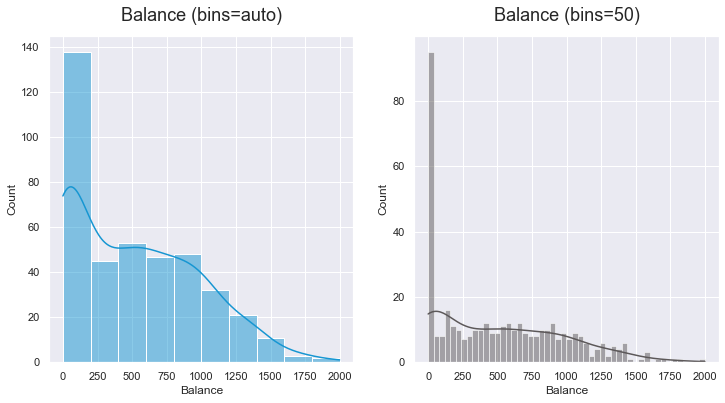

In [70]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.histplot(data=df, x='Balance', kde=True, ax=ax[0], color=colors['cyan'])
ax[0].set_title('Balance (bins=auto)', fontsize=18, pad=15)
sns.histplot(data=df, x='Balance', kde=True, bins=50, ax=ax[1], color=colors['gray'])
ax[1].set_title('Balance (bins=50)', fontsize=18, pad=15);

Visualizando os dados para valores de **Balance** > 0

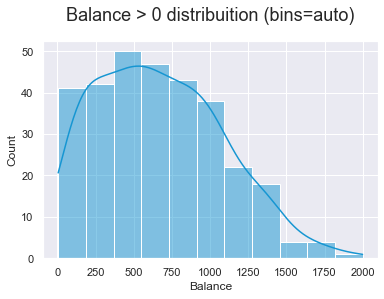

In [71]:
sns.histplot(data=df.query('Balance > 0'), x='Balance', kde=True, color=colors['cyan'])
plt.title('Balance > 0 distribuition (bins=auto)', fontsize=18, pad=20);

In [72]:
print(f'Balance = 0 : {df.query("Balance == 0").shape[0]}')
print(f'Balance > 0 : {df.query("Balance > 0").shape[0]}')

Balance = 0 : 90
Balance > 0 : 310


Podemos observar que muitos dados da coluna **Balance** estão com valores zerados. Isso pode significar que o usuário não utiliza o cartão de crédito, e isso pode prejudicar nosso modelo.

Portanto iremos adicionar uma coluna a mais que identifica se o usuário faz uso do cartão:

In [15]:
df['Use_card'] = np.where(df['Balance']>0, 'Yes', 'No')
df['Use_card'] = df['Use_card'].astype('category')
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Use_card
ID,,,,,,,,,,,,
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,Yes
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,Yes
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580,Yes
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964,Yes
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,Yes


#### Correlação dos Dados

Plotando um Heatmap para visualizar a correlação

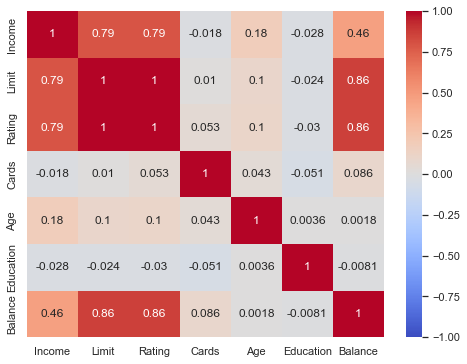

In [74]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1);

Checando se a correlação tem significância estatística:
- Balance x Income = 0.46
- Balance x Limit = 0.86
- Balance x Rating = 0.86
- Income x Limit = 0.79
- Income x Rating = 0.79
- Limit X Rating = 1

In [79]:
for category in ['Income','Limit', 'Rating']:
    r, p = pearsonr(df.Balance, df[category])
    print(f'Balance-{category} coef={r}; p-value={p}')

for category in ['Limit', 'Rating']:
    r, p = pearsonr(df.Income, df[category])
    print(f'Income-{category} coef={r}; p-value={p}')
    
r, p = pearsonr(df.Limit, df.Rating)
print(f'Limit-Rating coef={r}; p-value={p}')

Balance-Income coef=0.4636564570157574; p-value=1.030885802589071e-22
Balance-Limit coef=0.8616972670153954; p-value=2.530580711712837e-119
Balance-Rating coef=0.8636251606214953; p-value=1.8988990970393693e-120
Income-Limit coef=0.7920883413369415; p-value=2.3917894422844805e-87
Income-Rating coef=0.7913776251121218; p-value=4.362691443088444e-87
Limit-Rating coef=0.9968797370016829; p-value=0.0


<AxesSubplot:xlabel='Limit', ylabel='Rating'>

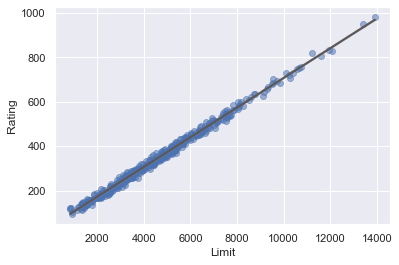

In [83]:
sns.regplot(data=df, x='Limit', y='Rating',
           scatter_kws={'alpha':0.5}, line_kws={'color':colors['gray']})

Ethnicity
African American    AxesSubplot(0.555556,0.125;0.344444x0.328261)
Asian               AxesSubplot(0.555556,0.125;0.344444x0.328261)
Caucasian           AxesSubplot(0.555556,0.125;0.344444x0.328261)
Name: Balance, dtype: object

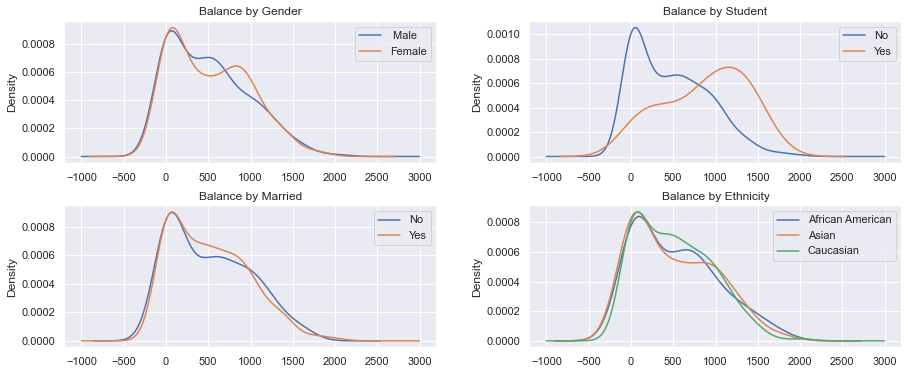

In [16]:
f, axes = plt.subplots(2, 2, figsize=(15, 6))
f.subplots_adjust(hspace=.3, wspace=.25)
df.groupby('Gender').Balance.plot(kind='kde', ax=axes[0][0], legend=True, title='Balance by Gender')
df.groupby('Student').Balance.plot(kind='kde', ax=axes[0][1], legend=True, title='Balance by Student')
df.groupby('Married').Balance.plot(kind='kde', ax=axes[1][0], legend=True, title='Balance by Married')
df.groupby('Ethnicity').Balance.plot(kind='kde', ax=axes[1][1], legend=True, title='Balance by Ethnicity')

#### Pair Plot

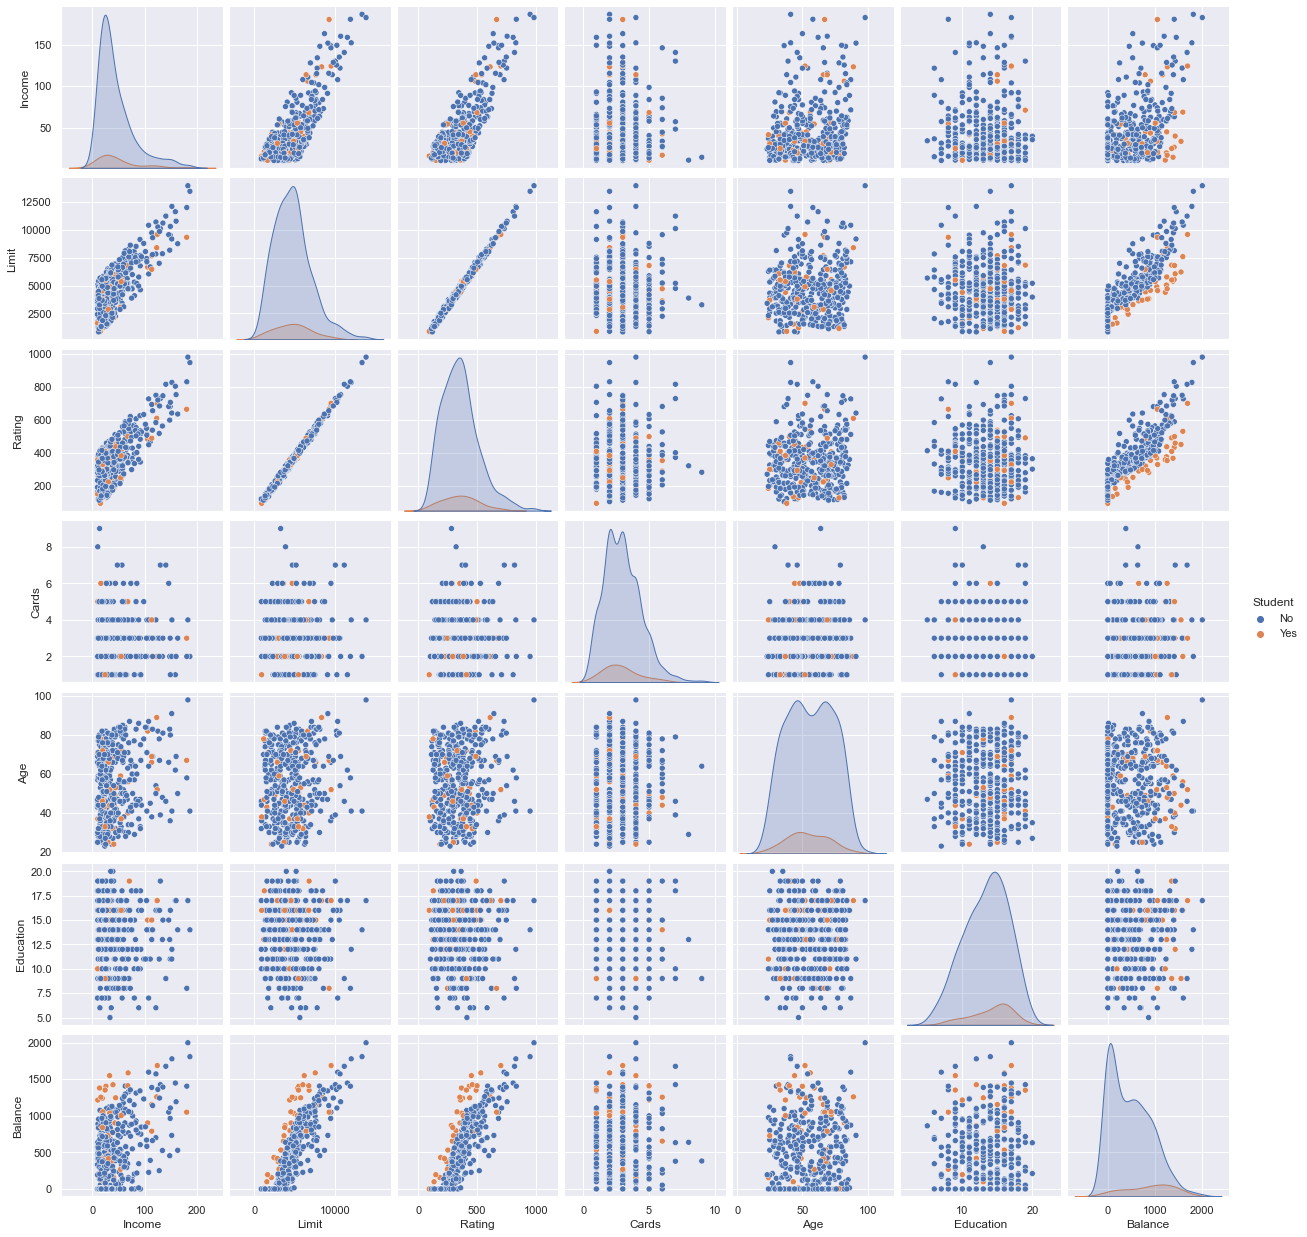

In [26]:
sns.pairplot(df, hue='Student')

#### Boxplot

<AxesSubplot:>

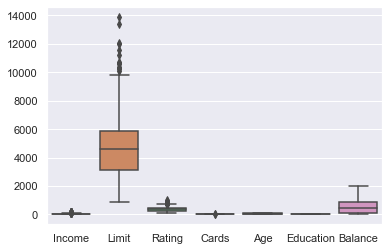

In [18]:
sns.boxplot(data=df[numerical_data])

<AxesSubplot:>

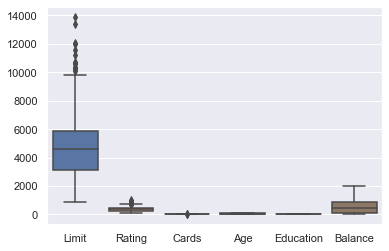

In [19]:
sns.boxplot(data=df.select_dtypes(include=['int64']))

#### Correlation Plot

In [20]:
df.corr()

,Income,Limit,Rating,Cards,Age,Education,Balance
Income,1.000000,0.792088,0.791378,-0.018273,0.175338,-0.027692,0.463656
Limit,0.792088,1.000000,0.996880,0.010231,0.100888,-0.023549,0.861697
Rating,0.791378,0.996880,1.000000,0.053239,0.103165,-0.030136,0.863625
Cards,-0.018273,0.010231,0.053239,1.000000,0.042948,-0.051084,0.086456
Age,0.175338,0.100888,0.103165,0.042948,1.000000,0.003619,0.001835
Education,-0.027692,-0.023549,-0.030136,-0.051084,0.003619,1.000000,-0.008062
Balance,0.463656,0.861697,0.863625,0.086456,0.001835,-0.008062,1.000000


### <span style='color:Gold'>Aplicando a Regressão Linear Multipla

In [22]:
def create_model_LR(df, features, predict):
    # Set variables
    if predict in features:
        X = df[features].drop(predict, axis=1)
        print(X.head())
    else:
        X = df[features]
        
    y = df[predict]
    # Train model
    lr = LinearRegression().fit(X,y)
    # Predict model
    y_est = lr.predict(X)
    # Results
    print('Coef: ', lr.coef_)
    print('Intercept: ', lr.intercept_)
    print('Score: ', lr.score(X,y))

    return lr


def create_model_SM(df, predict):
    # Set variables
    X = df.drop(predict, axis=1)
    y = df[predict]

    x = sm.add_constant(X)
    model = sm.OLS(y, x).fit()
    print(model.summary())
    print(f'Model mean: {model.resid.mean()}')

    fig, axes = plt.subplots(1,2,figsize=(12,6))
    sns.scatterplot(y, model.resid, ax=axes[0])
    sns.histplot(model2.resid, kde=True, ax=axes[1])

    return model


In [23]:
df2 = df.copy()

df2 = df2[df2.Balance!=0]

In [24]:
df2_dummies = pd.get_dummies(df2)

/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.366e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:18:45   Log-Likelihood:                -1162.5
No. Observations:                 310   AIC:                             2349.
Df Residuals:                     298   BIC:                             2394.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Income              

NameError: name 'model2' is not defined

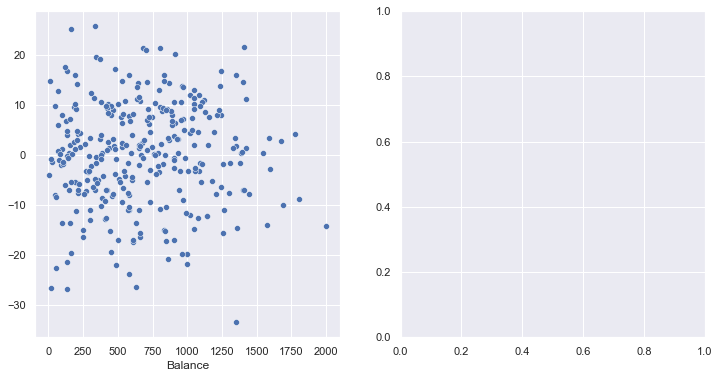

In [25]:
model = create_model_SM(df2_dummies, 'Balance')


/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.819e+04
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:51:44   Log-Likelihood:                -1162.5
No. Observations:                 310   AIC:                             2347.
Df Residuals:                     299   BIC:                             2388.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


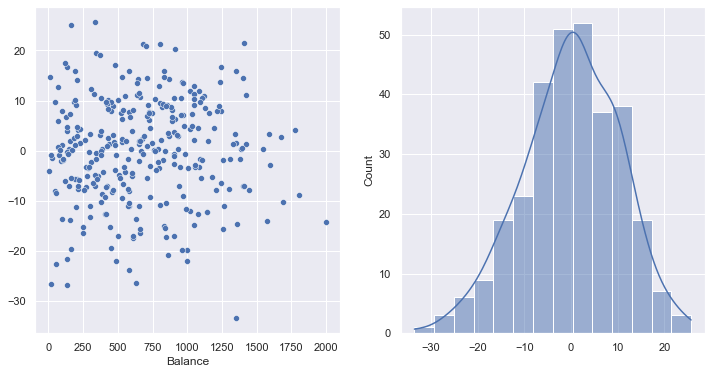

In [ ]:
model2 = create_model_SM(df2_dummies.drop('Education', axis=1), 'Balance')

In [ ]:
normaltest(model2.resid)[1]

0.1491618663491307

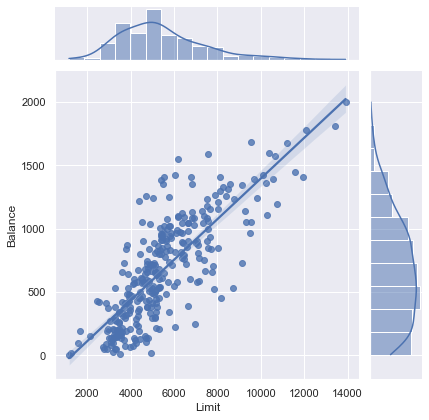

In [ ]:
sns.jointplot(data=df2_dummies, x='Limit', y='Balance', kind='reg')

In [ ]:
df_log = df2_dummies.copy()

In [ ]:
df_log[numerical_data] = df_log[numerical_data].apply(lambda x : np.log(x))

In [ ]:
X_final = df_log.drop('Balance', axis=1)
y_final = df_log.Balance

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=101)

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = np.exp(lr.predict(X_test))
y_true = np.exp(y_test)
r2_score(y_true, y_pred)

0.44669078874604395

In [ ]:
lr.score(X_train, y_train)

0.8319019362998288

#### Preparando as variáveis
X = Limit, Rating, Cards, Age, Education  
y = Balance  

In [ ]:
X = df[numerical_data].drop('Balance',axis=1)
X.head()

,Limit,Rating,Cards,Age,Education
ID,,,,,
1,3606,283,2,34,11
2,6645,483,3,82,15
3,7075,514,4,71,11
4,9504,681,3,36,11
5,4897,357,2,68,16


In [ ]:
y = df['Balance']
y.head()

ID
1    333
2    903
3    580
4    964
5    331
Name: Balance, dtype: int64

#### LinearRegression

In [ ]:
# Train model
lr_inital = LinearRegression().fit(X,y)
# Predict model
y_est_initial = lr_inital.predict(X)

In [ ]:
lr_inital.coef_ , lr_inital.intercept_

(array([ 0.10863397,  0.96906   , 22.90396758, -2.3943238 ,  2.71045969]),
 -309.2983224389775)

In [ ]:
lr_inital.score(X,y)

0.7572017149236498

#### Statsmodels

In [ ]:
x = sm.add_constant(X)

model = sm.OLS(y, x).fit()

model.summary()

/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     245.7
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          1.09e-118
Time:                        17:29:05   Log-Likelihood:                -2736.3
No. Observations:                 400   AIC:                             5485.
Df Residuals:                     394   BIC:                             5508.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -309.2983     76.724     -4.031      0.000    -460.137    -158.460
Limit          0.1086      0.075      1.453      0.147      -0.038       0.256
Rating         0.9691      1.117      0.867      0.386      -1.228       3.166
Cards         22.9040      9.934      2.306      0.022       3.374      42.434
Age           -2.3943      0.666     -3.597      0.000      -3.703      -1.086
Education      2.7105      3.666      0.739      0.460      -4.497       9.918
==============================================================================
Omnibus:                       20.680   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.060
Skew:                           0.375   Prob(JB):                     1.09e-07
Kurtosis:                       4.166   Cond. No.                     3.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Analisando o Erro da Regressão

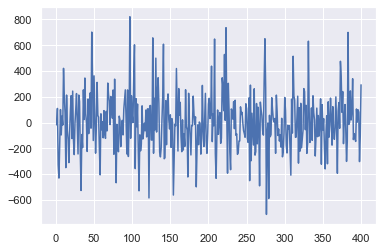

In [ ]:
model.resid
plt.plot(model.resid)

In [ ]:
model.resid.mean()

2.0740742456837323e-12

<AxesSubplot:ylabel='Count'>

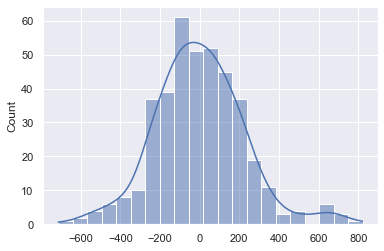

In [ ]:
sns.histplot(model.resid, kde=True)

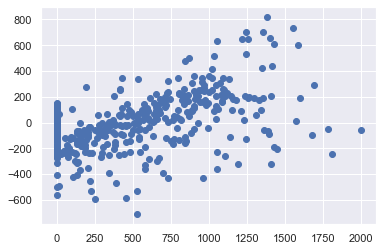

In [ ]:
plt.scatter(y, model.resid)

## 2. Estimando o Preço de Venda de Casas


O arquivo usa_housing.csv consiste em um dataset que contém informações sobre o preço de casas em determinadas regiões dos Estados Unidos. Uma descrição das colunas desse dataframes é apresentada abaixo:  
  
- Avg. Area Income: Média da renda dos residentes de onde a casa está localizada.  
- Avg. Area House Age: Média de idade das casas da mesma cidade.  
- Avg. Area Number of Rooms: Número médio de quartos para casas na mesma cidade.  
- Avg. Area Number of Bedrooms: Número médio de quartos para casas na mesma cidade.  
- Area Population: A população da cidade onde a casa está localizada.  
- Price: Preço de venda da casa.  
- Address: Endereço da casa.  
Utilize os dados contidos nele para criar um modelo de regressão linear que seja capaz de estimar o preço de venda das casas.  

### Analisando o Dataset

In [ ]:
df2 = pd.read_csv('https://s3-sa-east-1.amazonaws.com/lcpi/7cf57d48-ac3d-4748-9d81-5b4d6677fcff.csv')
df2.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386
